In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

In [2]:
# def parse_txr_file(filename):
#     try:
#         df = pd.read_csv(filename, skiprows=2, names=['t', 'x', 'y'])        
#         df = df.dropna()
#         df = df.apply(pd.to_numeric, errors='coerce').dropna()
        
#         return df
    
#     except FileNotFoundError:
#         print(f"Error: File '{filename}' not found.")
#         return None
#     except Exception as e:
#         print(f"Error reading file: {e}")
#         return None
def parse_txr_file(filename, water = False):
    try:
        if water:
            df = pd.read_csv(filename, skiprows=2, names=['t', 'x', 'y', 'theta', 'thetadot', 'thetadot2'])
            df = df.dropna()
            df = df.apply(pd.to_numeric, errors='coerce').dropna()
        else:
            df = pd.read_csv(filename, skiprows=2, names=['t', 'x', 'y', 'theta', 'thetadot'])
            df = df.dropna()
            df = df.apply(pd.to_numeric, errors='coerce').dropna()
        
        return df
    
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return None
    except Exception as e:
        print(f"Error reading file: {e}")
        return None
    
def snip_df(df, t_min):
    t_max = t_min + 60
    
    mean_theta = df["theta"].mean()
#     mean_theta = df["x"].mean()
    # slice
    window = df[(df["t"] >= t_min) & (df["t"] < t_max)].copy()

    # shift
    window["t"] = window["t"] - t_min
#     window["y"] = window["y"] - mean_y
#     window["y"] = np.arcsin(window["y"]/0.22)
    window["y"] = window["theta"] - mean_theta
    return window

def damped_oscillation(t, A, gamma, omega, phi, c):
    return A * np.exp(-gamma * t) * np.sin(omega * t + phi) + c

def estimate_initial_frequency(t, y):
    dt = np.mean(np.diff(t))
    freqs = np.fft.rfftfreq(len(y), d=dt)
    fft_mag = np.abs(np.fft.rfft(y - np.mean(y)))
    
    # Skip DC (0 frequency)
    idx_peak = np.argmax(fft_mag[1:]) + 1
    return 2 * np.pi * freqs[idx_peak]  # angular frequency

def plot(df, t_min=0, window=30, show_trend=True, fit_damped=False, return_params=False, med=None, naming = None):
    t_max = t_min + window
    df_snip = df[(df['t'] >= t_min) & (df['t'] <= t_max)]

    fig, ax = plt.subplots(figsize=(12, 2))

#     # Center y around its mean
#     y_mean = df_snip['y'].mean()
    y_centered = df_snip['y'] 

    # Scatter plot
    ax.scatter(
        df_snip['t'], y_centered,
        color='green', marker="+", alpha=0.6, label="Data"
    )

    # Optional trend line
    if show_trend:
        ax.plot(df_snip['t'], y_centered, color='black', alpha=0.4, linewidth=1)

    fitted_params = None

    # Fit damped oscillation if requested
    if fit_damped:
        t_data = df_snip['t'].values
        y_data = y_centered.values

        # Initial guesses
        A0 = np.std(y_data)
        gamma0 = 0.01
        omega0 = estimate_initial_frequency(t_data, y_data)
        phi0 = 0
        c0 = 0

        try:
            popt, _ = curve_fit(
                damped_oscillation, t_data, y_data,
                p0=[A0, gamma0, omega0, phi0, c0],
                bounds=([0, 0, 0, -np.pi, -np.inf],
                        [np.inf, np.inf, np.inf, np.pi, np.inf]),
                maxfev=10000
            )
            fitted_params = popt
            y_fit = damped_oscillation(t_data, *popt)
            ax.plot(t_data, y_fit, color='blue', linewidth=2, label="Fit")

            # Compute period
            omega = popt[2]
            period = 2 * np.pi / omega
#             ax.text(
#                 0.95, 0.95, f"Period T ≈ {period:.2f}", 
#                 transform=ax.transAxes, fontsize=12,
#                 verticalalignment='top', horizontalalignment='right',
#                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
#             )
        except RuntimeError:
            print("⚠️ Fit did not converge.")

    # Add reference line
#     ax.axhline(0, color='red', linestyle="--", linewidth=1, label="Mean")

    # Labels and title
    ax.set_xlabel('Time (t)', fontsize=12)
    ax.set_ylabel(r'$\theta$ ', fontsize=12)
#     ax.set_title(f'{med.title()}: {naming} ', fontsize=14, weight="bold")

    # Grid & legend
    ax.grid(True, linestyle=":", alpha=0.7)
    ax.legend()

    plt.tight_layout()
    plt.savefig(f"plots/{med}-{naming}.pdf")
    plt.show()

    if return_params:
        return fitted_params

In [3]:
names = {
    0: "M1-SA",
    1: "M1-BA", 
    2: "M2-SA", 
    3: "M2-BA"
}

In [4]:
data_files = "Final Data"
vid_air = [1, 8, 12, 13]
vid_water = [17, 18, 19, 20]
dfs = {}
for i, vid in enumerate(vid_air):
    filename = f"{data_files}/Vid_{vid}.txt"
    dfs[f"air_{names[i]}"] = parse_txr_file(filename)

for i, vid in enumerate(vid_water):
    filename = f"{data_files}/Vid_{vid}.txt"
    dfs[f"water_{names[i]}"] = parse_txr_file(filename, water = True)

In [5]:
# dfs

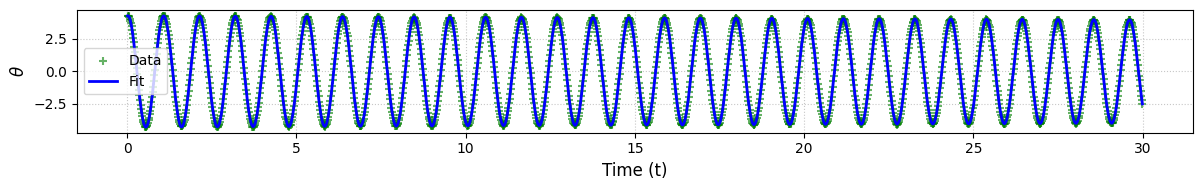

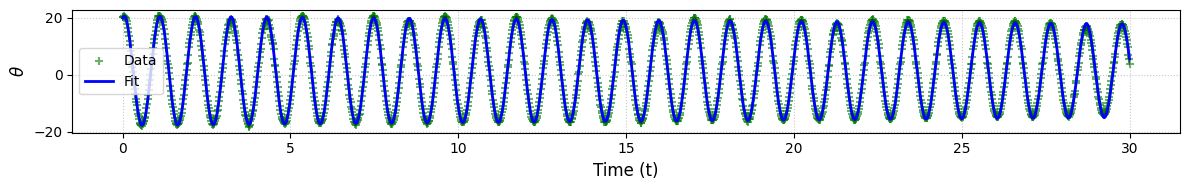

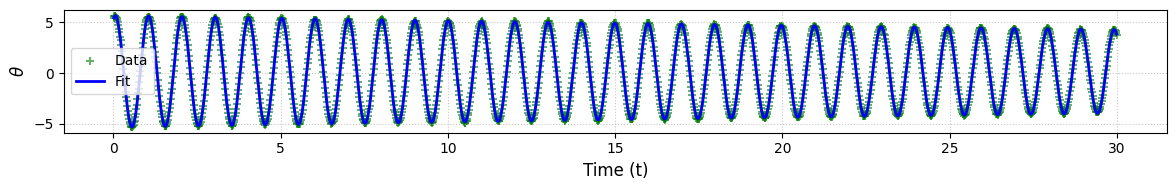

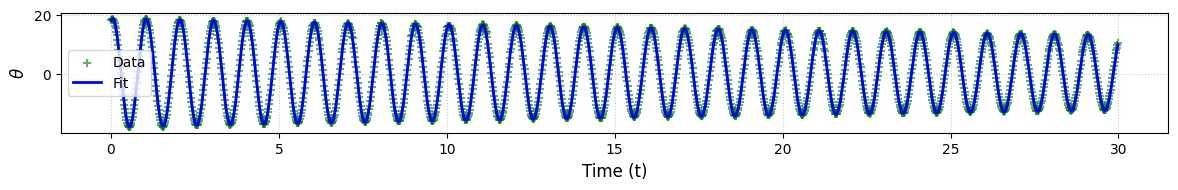

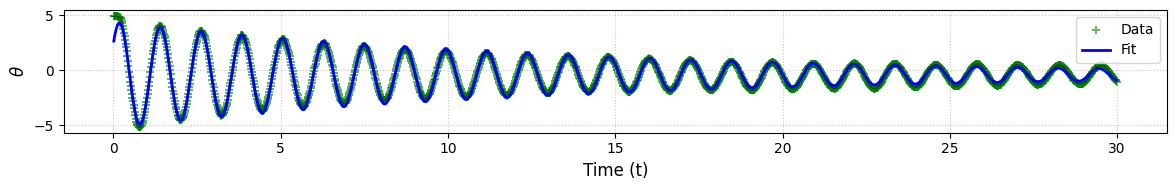

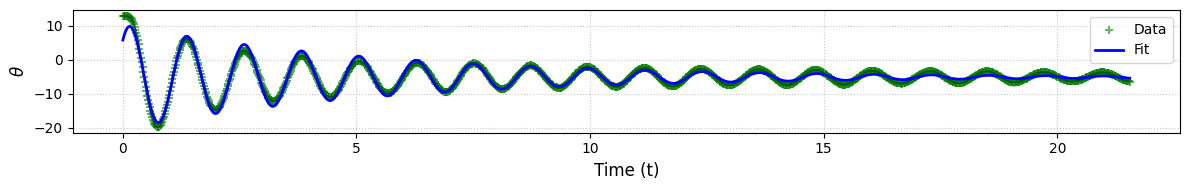

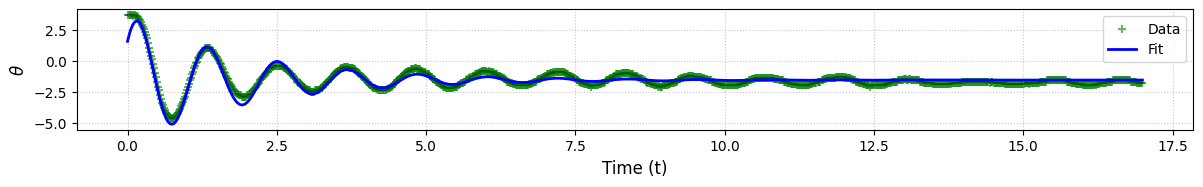

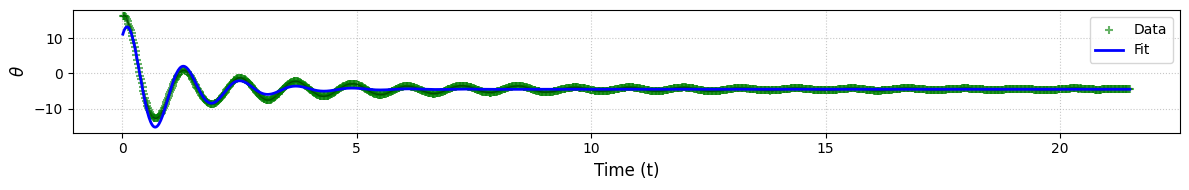

In [6]:
# Clean and plot

air_start = [30.15, 3.55, 2.85, 2]
for i, vid in enumerate(vid_air):
    dfs[f"air_{names[i]}"] = snip_df(dfs[f"air_{names[i]}"], air_start[i]).copy()
    plot(dfs[f"air_{names[i]}"],t_min=0, window=30, show_trend=True, fit_damped=True, med = "air", naming = names[i])

# Load "small angle" data
water_start = [2.4, 8.4, 6.4, 5.8]
for i, vid in enumerate(vid_water):
    dfs[f"water_{names[i]}"] = snip_df(dfs[f"water_{names[i]}"], water_start[i]).copy()
    plot(dfs[f"water_{names[i]}"], t_min=0, window=30, show_trend=True, fit_damped=True, med = "water", naming = names[i])

In [7]:
def estimate_fluid_density_damped(df, L, m, V, m_a=0.0, g=9.81, t_min=0, window=None, ax=None,
                                 sigma_m=0.001, sigma_L=0.01, sigma_V=2.5e-6, sigma_m_a=0.0, sigma_g=0.0):
    if window is not None:
        t_max = t_min + window
        df_snip = df[(df['t'] >= t_min) & (df['t'] <= t_max)]
    else:
        df_snip = df

    t_data = df_snip['t'].values
    y_data = df_snip['y'].values 

    A0 = np.std(y_data)
    gamma0 = 0.01
    omega0 = estimate_initial_frequency(t_data, y_data)
    phi0 = 0
    c0 = 0

    try:
        popt, pcov = curve_fit(
            damped_oscillation, t_data, y_data,
            p0=[A0, gamma0, omega0, phi0, c0],
            bounds=([0, 0, 0, -np.pi, -np.inf],
                    [np.inf, np.inf, np.inf, np.pi, np.inf]),
            maxfev=10000
        )
        omega = popt[2]
        sigma_omega = np.sqrt(pcov[2, 2])  # Uncertainty in omega
        T = 2 * np.pi / omega

        # Calculate moment of inertia
        I = m * L**2

        # Calculate fluid density
        rho_f_est = (m - ((I + m_a * L**2) * omega**2) / (g * L)) / V

        # Uncertainty propagation
        # Partial derivatives for error propagation
        d_rho_d_m = 1 / V
        d_rho_d_I = -omega**2 / (g * L * V)
        d_rho_d_m_a = -L**2 * omega**2 / (g * L * V)
        d_rho_d_omega = -2 * omega * (I + m_a * L**2) / (g * L * V)
        d_rho_d_g = (I + m_a * L**2) * omega**2 / (g**2 * L * V)
        d_rho_d_L = -(m_a * omega**2 * 2 * L / (g * V) - (I + m_a * L**2) * omega**2 / (g * L**2 * V))
        d_rho_d_V = -(m - ((I + m_a * L**2) * omega**2) / (g * L)) / V**2

        # Uncertainty in I due to m and L
        sigma_I = np.sqrt((L**2 * sigma_m)**2 + (2 * m * L * sigma_L)**2)

        # Total uncertainty in rho_f
        sigma_rho_f = np.sqrt(
            (d_rho_d_m * sigma_m)**2 +
            (d_rho_d_I * sigma_I)**2 +
            (d_rho_d_m_a * sigma_m_a)**2 +
            (d_rho_d_omega * sigma_omega)**2 +
            (d_rho_d_g * sigma_g)**2 +
            (d_rho_d_L * sigma_L)**2 +
            (d_rho_d_V * sigma_V)**2
        )

        if ax is not None:
            y_fit = damped_oscillation(t_data, *popt)
            ax.plot(t_data, y_data, 'k.', alpha=0.5, label="Data")
            ax.plot(t_data, y_fit, 'b-', lw=2, label="Fit")
            ax.text(
                0.95, 0.95, f"T ≈ {T:.2f} s\nρ_f ≈ {rho_f_est:.2f} ± {sigma_rho_f:.2f} kg/m³",
                transform=ax.transAxes, fontsize=12,
                va='top', ha='right',
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
            )
            ax.legend()

        return rho_f_est, sigma_rho_f, T, popt, pcov

    except RuntimeError:
        print("⚠️ Fit did not converge.")
        return None, None, None, None, None

In [8]:
rho_calc = []
for key, df in dfs.items():
    if df is None or 'water' not in key:
        continue
    if key.split("_")[1].split("-")[0] == "M1":
        m = 0.5
        V = 8.5e-5
        L = 0.3
    elif key.split("_")[1].split("-")[0] == "M2":
        m = 0.05
        V = 1e-5
        L = 0.27
#     theta = df['y'].values
#     if np.max(np.abs(theta)) > 2*np.pi:
#         theta = np.deg2rad(theta)
    rho_est, rho_unc, T_avg, popt, pcov = estimate_fluid_density_damped(df, L, m, V, m_a=0.0)
    if "air" in key:
        rho_calc.append(1.225)
        
    else: 
        rho_calc.append(rho_est)
    print(f"Run {key}: estimated water density = {rho_est:.2f} kg/m^3 unc: {rho_unc:.2f}")

Run water_M1-SA: estimated water density = 1111.32 kg/m^3 unc: 357.43
Run water_M1-BA: estimated water density = 1152.06 kg/m^3 unc: 354.55
Run water_M2-SA: estimated water density = 1063.69 kg/m^3 unc: 439.82
Run water_M2-BA: estimated water density = 1223.75 kg/m^3 unc: 455.60


In [9]:
# print(rho_calc)

In [10]:
from scipy.signal import savgol_filter
from scipy.optimize import lsq_linear

def identify_ls_paper(df, L, m, V, rho_f=1000.0, m_a_guess=0.0, g=9.81):
    """
    Identify hydrodynamic coefficients using paper's LS method.
    Assumes df['y'] is angle in radians (snipped & centered).
    """
    t = df['t'].values
    y = df['y'].values 
#     print("Total Data:", len(y))
#     print(max(y))
#     print(df.columns)
    # --- Preprocess & derivatives (Savitzky-Golay smoothing) ---
    wl = min(21, len(y) - 1 if (len(y)-1)%2==1 else len(y)-2)
    wl = max(wl, 5)
    y_smooth = savgol_filter(y, wl, 3)
    dt = np.mean(np.diff(t))
    theta_dot = savgol_filter(y_smooth, wl, 3, deriv=1, delta=dt)
    theta_ddot = savgol_filter(y_smooth, wl, 3, deriv=2, delta=dt)
    
    
    alpha = (rho_f*V*g - m*g)/((m+m_a_guess)*L)
#     alpha = (m - rho_f*V) * g / L  # if L is distance to CoM

    # --- Build LS system ---
    H = np.column_stack([
        -theta_dot,
        -theta_dot * np.abs(theta_dot)
    ])
    y_resp = theta_ddot - alpha*np.sin(y_smooth)

    # LS solve
    p, residuals, rank, s = np.linalg.lstsq(H, y_resp, rcond=None)
    
#     plt.plot(t, theta_ddot, label='θ̈')
#     plt.plot(t, alpha*np.sin(y_smooth), label='α sinθ')
#     plt.plot(t, -theta_dot, label='-θ̇')
#     plt.plot(t, -theta_dot * np.abs(theta_dot), label='-|θ̇| θ̇')
#     plt.legend()
#     plt.show()

#     H2 = np.column_stack([np.sin(y_smooth), -theta_dot, -theta_dot*np.abs(theta_dot)])
#     p2, _, _, _ = np.linalg.lstsq(H2, theta_ddot, rcond=None)
#     alpha_fit, beta_fit, gamma_fit = p2
    
#     print(alpha_fit, beta_fit, gamma_fit)
    # alpha, beta, gamma
    E, J = p
    res = y_resp - H @ p
    rms = np.sqrt(np.mean(res**2))/(max(res) - min(res))*100


    K_L = E*(m+m_a_guess)
    K_Q = J*(m+m_a_guess)/L
    try:
        _, period, _ = estimate_fluid_density_damped(df, L, m, V)
        if period is not None:
            omega = 2*np.pi/period
            I_eff = (m - rho_f*V) * g * L / (omega**2)
            m_a_est = (I_eff - I) / (L**2)
        else:
            m_a_est = np.nan
    except Exception:
        period, m_a_est = np.nan, np.nan

    return {
        "t": t,
        "theta": y_smooth,
        "theta_dot": theta_dot,
        "theta_ddot": y_resp,
        "y_fit": H @ p, "E": E, "J": J,
        "K_L": K_L,
        "K_Q": K_Q,
        "m_a_est": m_a_est,
        "rms": rms,
        "period": period
    }


def plot_with_ls(df, L, m, V, run_key="run", rho_f=1000.0):
    """
    Combined plot: damped oscillation fit + LS hydrodynamics fit.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4), sharex=True)

    # --- Top: damped oscillation fit ---
    rho_est, rho_unc,T_avg, popt, popv = estimate_fluid_density_damped(df, L, m, V, ax=ax1)
    ax1.set_title(f"{run_key} - Damped Fit: T ≈ {T_avg:.2f}s, ρ ≈ {rho_est:.1f} kg/m³")
    ax1.set_ylabel("θ (rad)")

    # --- Bottom: LS fit ---
    res = identify_ls_paper(df, L, m, V, rho_f=rho_f)
    ax2.plot(res["t"], res["theta_ddot"], 'k-', lw=1, label="θ̈ measured")
    ax2.plot(res["t"], res["y_fit"], 'r--', lw=2, label="θ̈ LS fit")
    ax2.set_title(
        f"LS fit: E={res['E']:.2e}, J={res['J']:.2e}, "
        f"K_L={res['K_L']:.2e}, K_Q = {res['K_Q']:.2e}, RMS={res['rms']:.2e}" 
    )
    ax2.set_xlabel("t (s)")
    ax2.set_ylabel("θ̈ (rad/s²)")
    ax2.legend()

    plt.tight_layout()
#     plt.show()
    return res



=== Hydrodynamic Coefficient Identification ===
Run water_M1-SA:, $beta$=-4.283e-02, $gamma$=3.548e-03, K_L=-0.021, K_Q = 0.005913633742655953, RMS=1.257e+01
Run water_M1-BA:, $beta$=-3.191e-03, $gamma$=6.533e-05, K_L=-0.002, K_Q = 0.00010887756929685534, RMS=1.321e+01
Run water_M2-SA:, $beta$=-1.051e-01, $gamma$=1.326e-02, K_L=-0.005, K_Q = 0.00245498420920715, RMS=1.654e+01
Run water_M2-BA:, $beta$=-2.363e-02, $gamma$=-6.094e-04, K_L=-0.001, K_Q = -0.00011285335913412414, RMS=8.509e+00
Saved hydrodynamic ID results to hydro_id_results.csv


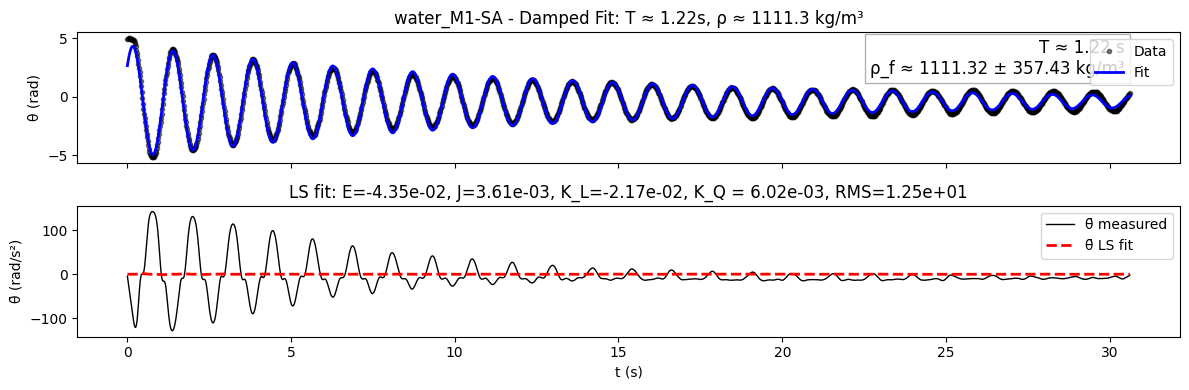

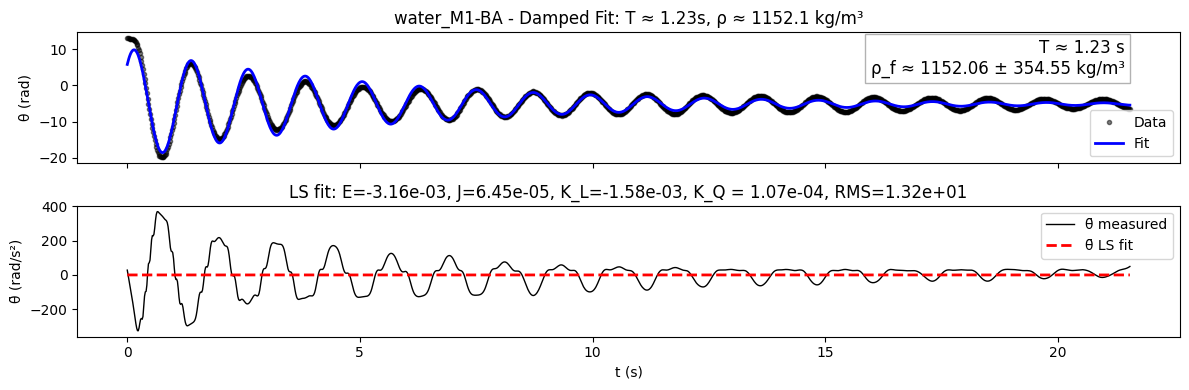

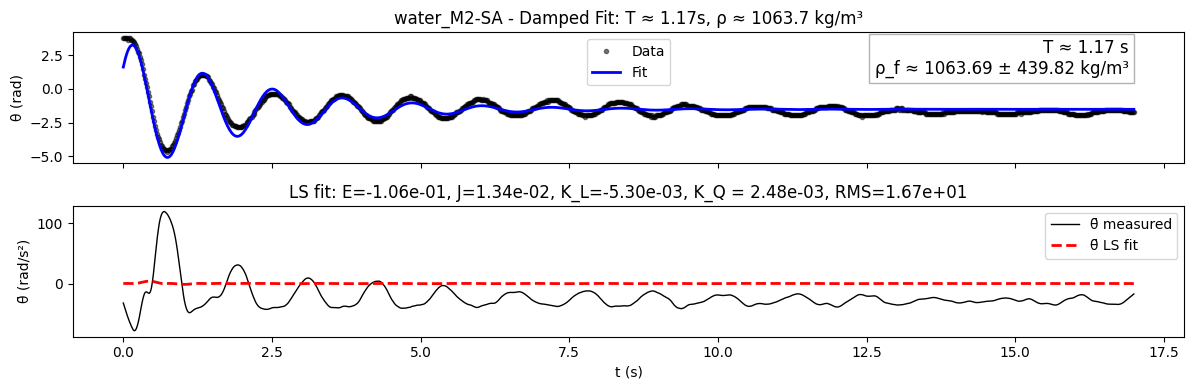

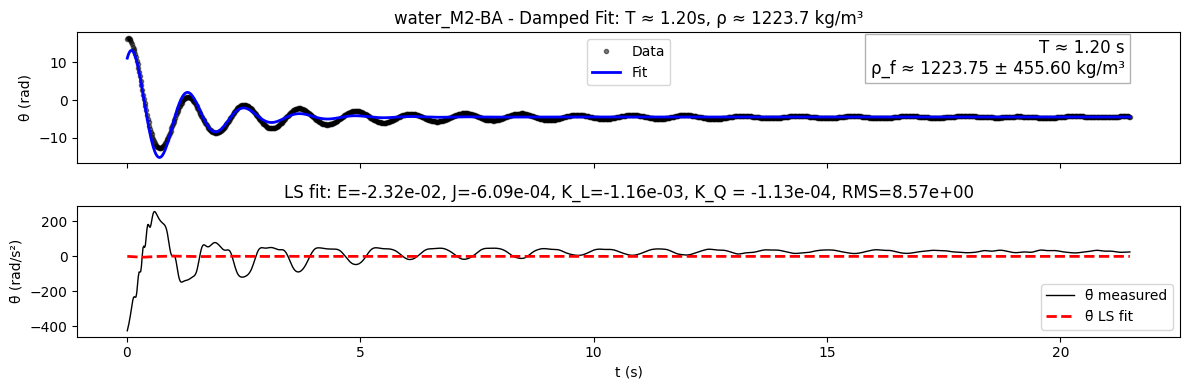

In [11]:
print("\n=== Hydrodynamic Coefficient Identification ===")
results = []
c = 0
for key, df in dfs.items():
    if df is None or "water" not in key:
        continue
    if key.split("_")[1].split("-")[0] == "M1":
        m = 0.5
        V = 8.5e-5
        L = 0.3
    elif key.split("_")[1].split("-")[0] == "M2":
        m = 0.05
        V = 1e-5
        L = 0.27

    res = identify_ls_paper(df, L=L, m=m, V=V, rho_f=rho_calc[c])
    plot_with_ls(df, L=L, m=m, V=V, run_key=key)
    c += 1
    results.append({"run": key, **res})
    print(f"Run {key}:, $beta$={res['E']:.3e}, $gamma$={res['J']:.3e}, "
#           f"b={res['b_est']:.3e}, d={res['d_est']:.3e}, m_a={res['m_a_est']:.3e}, "
          f"K_L={res['K_L']:.3f}, K_Q = {res['K_Q']}, RMS={res['rms']:.3e}")

# Save to CSV
pd.DataFrame(results).to_csv("hydro_id_results.csv", index=False)
print("Saved hydrodynamic ID results to hydro_id_results.csv")
